# Objective

# Topic Modelling and Community Cluster Detection

Topic modelling takes a single text or corpus and looks for patterns in the use of words, it is an attempt to inject semantic meaning to vocabulary. It assumes that any piece of text is composed by selecting words from possible baskets of words where each basket corresponds to a topic. The process iterates multiple times till it has the most likely distribution of words into baskets which are named as topics.The challenge, however, is how to extract good quality of topics that are clear, segregated and meaningful. We have tried to implement 2 variants of Latent Dirichlet Allocation(LDA) as it is a popular algorithm for topic modeling for small documents like tweets.


## Import necessary modules

In [1]:
import pandas as pd
import functools
import re

from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from nltk.util import ngrams
from nltk import FreqDist
from textblob import TextBlob

import warnings
warnings.filterwarnings('ignore')

# Plotting tools
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_colwidth', -1)


## Read and Preprocess data

We use Humans.csv as the input file for this analysis which was generated after discarding the fake accounts('') and cleaning the tweets with standard NLP techniques(''). Thus this file comprises of cleaned tweets from accounts that are not fake. We read the required columns from this file as a pandas dataframe and apply the following preprocessing steps:
* *Drop any column that has missing values*
* *Filter out the retweets since they are textually same as the original tweets.*
* *Filter out records if they are NAN*
* *Merge records by users to understand..........*
* *Remove # from hashtags and convert to lower case*
* *Remove punctuations and tokennize the tweets*

In [2]:
# check NAN
def isNaN(num):
    return num != num

In [3]:
# Read data
read_df = pd.read_csv("humans.csv", sep = ';', index_col=None, usecols = ['screen_name', 'hashtags', 'lemma_filter','retweets_count'])

# Preprocess Data
df = read_df.reset_index().dropna()
df = df[df['retweets_count'] == 0]
df = df[df.apply(lambda x: (isNaN(x['lemma_filter'])==False) and (isNaN(x['screen_name'])==False), axis=1)]

# Merge tweets and hashtags by user and clean hashtags
temp0 = df.groupby('screen_name').size().reset_index(name='counts')
temp1 = df.groupby('screen_name')['lemma_filter'].apply(' '.join).reset_index()
temp2 = df.groupby('screen_name')['hashtags'].apply(','.join).reset_index()
data_frames = [temp0,temp1,temp2]
tweets = functools.reduce(lambda  left,right: pd.merge(left,right,on=['screen_name'], how='inner'), data_frames)
tweets['hashtags_list'] = tweets.apply(lambda x: [i for i in set(re.findall(r"[\w']+", x['hashtags'].lower())) if len(i) > 1], axis=1)
tweets = tweets[['screen_name', 'lemma_filter', 'hashtags_list']].reset_index()
tweets['index'] = tweets.index

#print the first two cleaned records
tweets.head(2)


,index,screen_name,lemma_filter,hashtags_list
0,0,0.bts.officials.0,—————————————————————————— wish lucky 🍀 —————————————————————————— • • • • 🥀🍀🥀 • • • • • • 🥀🍀🥀,"[teahung, bangtanboys, cute, girl, lucky, inlove, metoo, bts, love, korea, sweet]"
1,1,0.gin.ger.0,"🌻 •love ! -so give u right attack purposefully sag pant well , right ?","[nomeansno, thisisnotconsent, metoo, consentissexy, nomeansnoworldwide]"


In [7]:
# Remove punctuations and tokennize the tweets
def token_words(sentence):
    return [i for i in (simple_preprocess(str(sentence), deacc=True))]

tweets['processed_lemma_filter'] = tweets.apply(lambda x: token_words(x['lemma_filter']), axis=1)
data = tweets['processed_lemma_filter'].values

## Check the most frequent words being used

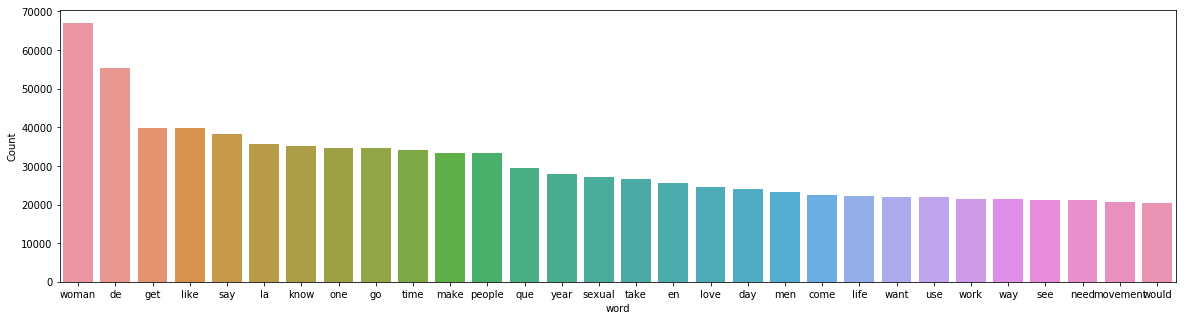

In [5]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

vis_data = []
for i in range(len(data)):
    vis_data.append(' '.join(data[i]))

freq_words(vis_data)

## Prepare the corpus for LDA and apply Frequency Filter

The two main inputs the topic model are the dictionary(id2word) and the corpus. We filter out very frequent or very rare words as we find in the above diagram that the choise of words are not great.

In [8]:
#Build a Dictionary(associate word to numeric id)
id2word = corpora.Dictionary(data)

# ignore words that appear in less than 20 documents or more than 10% documents
id2word.filter_extremes(no_below=20, no_above=0.1)
# print(id2word)

#Preparing Document-Term Matrix(word_id to word_freq)
corpus = [id2word.doc2bow(text) for text in data]
print("the corpus for the 20th tweet")
print(corpus[0])
print("the words of the 20th tweet with the freq")
# [(id2word[i[0]],i[1]) for i in corpus[0]] ##print([[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]])


the corpus for the 20th tweet
[(0, 1), (1, 1)]
the words of the 20th tweet with the freq


## Build Topic Model with optimal number of topics

We build the LDA model with gensim library. We train two variants of LDA, the basic version which is probabilistic topic modelling and the MalletLDA which is implementation of Gibbs sampling In order to get the optimal number of topics we build many LDA models with different number of topics and choose the one with the highest accuracy. Accuracy is measured by coherence score. Higher the score, better the model.

In [12]:
# function to get optimal number of topics LDA
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    model_list = []
    coherence_values = []
    
    for num_topics in range(start, limit, step):
        lda_model = models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=100, update_every=1, chunksize=500, passes=10,
                                            alpha='auto', per_word_topics=True)
        model_list.append(lda_model)
        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

LDAmodel_list, coherence_values_lda = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data, start=2, limit=20, step=6)

print("coherence score of LDA model")
print(coherence_values_lda)

coherence score of LDA model
[0.5520639938136651, 0.507294872215525, 0.4740843644283462]


#### Mallet model often gives a better result but takes a very long time to train. Please download the the zip file, unzip it and give proper path to execute this piece of code

In [14]:
# Mallet’s version, however, often gives a better quality of topics.
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip 
import os
from gensim.models.wrappers import LdaMallet
os.environ.update({'MALLET_HOME':r'C:/mallet_new/mallet-2.0.8/'}) # change the path as required
mallet_path = 'C:\\mallet_new\\mallet-2.0.8\\bin\\mallet' # change the path as required

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    Mallet_coherence_values = []
    Malletmodel_list = []
    
    for num_topics in range(start, limit, step):
        Malletmodel = LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        Malletmodel_list.append(Malletmodel)
        coherencemodel = CoherenceModel(model=Malletmodel, texts=texts, dictionary=dictionary, coherence='c_v')
        Mallet_coherence_values.append(coherencemodel.get_coherence())
        
    return Malletmodel_list, Mallet_coherence_values

Malletmodel_list, Mallet_coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data, start=2, limit=20, step=6)

print("coherence score of MalletLDA model")
print(Mallet_coherence_values)

coherence score of MalletLDA model
[0.34909725335163844, 0.635553800712542, 0.6283341502461341]


In [18]:
max_coherence=0
index=0
coherence = coherence_values_lda #Replace it with Mallet_coherence_values for Mallet model
model = LDAmodel_list #Replace it with Malletmodel_list for Mallet model

for i in coherence:
    if i > max_coherence:
        max_coherence = i
        index = coherence.index(i)
optimal_model = model[index]
print(index)
print(optimal_model)

for idx in range(2):
    # Print the first 10 most representative topics
    print("Topic #%s:" % idx, optimal_model.print_topic(idx, 10))

0
LdaModel(num_terms=19125, num_topics=2, decay=0.5, chunksize=500)
Topic #0: 0.005*"day" + 0.004*"love" + 0.004*"need" + 0.004*"life" + 0.004*"come" + 0.004*"men" + 0.004*"work" + 0.004*"see" + 0.004*"way" + 0.004*"want"
Topic #1: 0.039*"de" + 0.024*"la" + 0.018*"que" + 0.016*"en" + 0.009*"el" + 0.008*"le" + 0.008*"un" + 0.006*"se" + 0.006*"et" + 0.005*"och"


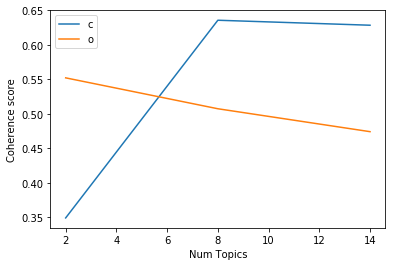

Num Topics Mallet = 2  has Coherence Value of 0.3491
Num Topics Mallet = 8  has Coherence Value of 0.6356
Num Topics Mallet = 14  has Coherence Value of 0.6283
Num Topics LDA = 2  has Coherence Value of 0.5521
Num Topics LDA = 8  has Coherence Value of 0.5073
Num Topics LDA = 14  has Coherence Value of 0.4741


In [15]:
# Show graph
limit=20; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, Mallet_coherence_values)
plt.plot(x, coherence_values_lda)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

#Print the coherence scores
for m, cv in zip(x, Mallet_coherence_values):
    print("Num Topics Mallet =", m, " has Coherence Value of", round(cv, 4))
for m, cv in zip(x, coherence_values_lda):
    print("Num Topics LDA =", m, " has Coherence Value of", round(cv, 4))

## EDA on Topic Modelling

Here we find the dominant topic in each sentence. One of the practical application of topic modeling is to determine what topic a given document is about.To find that, we find the topic number that has the highest percentage contribution in that document.

In [ ]:

topics = lda_model.get_document_topics(corpus, per_word_topics=True)
all_topics = [(doc_topics, word_topics, word_phis) for doc_topics, word_topics, word_phis in topics]
#print(all_topics)

Topic_df= pd.DataFrame()
for doc_topics, word_topics, word_phis in all_topics:
    #print("new doc")
    new_doc=sorted(doc_topics,key=lambda x: x[1], reverse=True)
    for j,(topic_num, prop_topic) in enumerate(new_doc):
        if j==0:
            topic_word = lda_model.show_topic(topic_num)
            topic_keywords = ", ".join([word for word, prop in topic_word])
            
            Topic_df = Topic_df.append(pd.Series([int(topic_num), round(prop_topic,4),topic_keywords]), ignore_index=True)
        else:
            break
Topic_df.columns = ['Dominant_Topic', 'Perc_Contribution','topic_keywords']
# Add original text to the end of the output
contents = pd.Series(tweets['screen_name'])
Topic_df = pd.concat([Topic_df, contents], axis=1)
Topic_df

## Bar plot of number of documents per topic.

In [ ]:
#print(Topic_df['Dominant_Topic'])
# Number of Documents for Each Topic
temp=Topic_df.groupby('Dominant_Topic').agg('count').reset_index()
topic_counts=temp[['Dominant_Topic','screen_name']]

# Percentage of Documents for Each Topic
topic_counts['topic_contribution'] = round(topic_counts['screen_name']/topic_counts['screen_name'].sum(), 4)
topic_counts.columns=['Dominant_Topic', 'Num_Documents', 'Perc_Documents']

#Plot the topics
sns.set_style("whitegrid", {'axes.grid' : False})
#plt.figure(figsize=(15,5))
ax = sns.barplot(data=topic_counts, x= "Dominant_Topic", y = "Num_Documents",  palette=("Blues_d"))
ax.set(xlabel = 'Topics')
sns.set_context("poster")
labels = [str(round(i,2))+'%' for i in topic_counts['Perc_Documents']]
rects = ax.patches

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            fontsize=15, color='blue', ha='center', va='bottom')

plt.show()

## Visualize the word distribution

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(LDAmodel_list[1], corpus, id2word)
vis

## Similarity between the documents

In [ ]:
import numpy as np
topics = lda_model.get_document_topics(corpus, per_word_topics=True)
doc_topic_matrix = np.zeros((len(data), NUM_TOPICS))

for idx, i in enumerate(topics):
    for j in i[0]:
        doc_topic_matrix[idx, j[0]] = j[1]

cos_sim = doc_topic_matrix.dot(doc_topic_matrix.T)
cos_sim = cos_sim - np.eye(len(data))
I,J = np.where(cos_sim > 0.7)
col = np.column_stack((I,J,cos_sim[I,J]))
with open('similaritygraph.txt', 'w') as f:
    for row in col:
        if row[0] < row[1]:
            f.write('{}\t{}\t{}\n'.format(int(row[0]),int(row[1]),row[2]))

In [ ]:
#!pip install infomap
!infomap similaritygraph.txt sim_output/ -N 5 --clu

In [ ]:
import pandas as pd
nodes = pd.read_csv('sim_output/similaritygraph.clu', sep=' ', header=None, skiprows=2, names=['id', 'label', 'score'])
edges = pd.read_csv('similaritygraph.txt', sep='\t', header=None, names=['source', 'target', 'weight'])
id_mapping = pd.read_csv('similarity_id_mapping.csv', sep=';')

In [ ]:
from textblob import TextBlob

ht_df = pd.read_csv('ouput.results', sep='\t', index_col='ID')[['Node', 'Label']]
ht_df['Label'] = ht_df.apply(lambda x: 1.0 if x['Label'] == 'pos' else (0.0 if x['Label'] == 'neg' else 0.5), axis=1)

ht_dic = ht_df.set_index('Node').to_dict()['Label']

#Classifier
def get_hashtag_polarity(tweet, hashtag_list):
    polarity = 0.0
    count = 0.0
    tweet_polarity = TextBlob(tweet).sentiment[0]
    for ht in hashtag_list:
        if ht in ht_dic:
            polarity += ht_dic[ht]
            count += 1.0
    if count > 0:
        polarity = polarity/count
        result_polarity = (tweet_polarity+polarity)/2.0
    else:
        result_polarity = tweet_polarity
    return [polarity, result_polarity, 'pos' if result_polarity > 0.6 else ('neg' if result_polarity < 0.4 else 'neutral')]
     

In [ ]:
id_mapping['sentiment'] = id_mapping.apply(lambda x: get_hashtag_polarity(x['lemma_filter'], x['hashtags_list']), axis=1)
nodesdf = pd.merge(nodes, id_mapping[['index', 'sentiment']], left_on=['id'], right_on=['index'], how='inner')
nodesdf['sentiment'] = nodesdf.apply(lambda x: x['sentiment'][2], axis=1)
nodesdf.drop('index', axis=1).to_csv('similarity_graph_nodes.csv', sep=',', header=True, index=None)
edges.to_csv('similarity_graph_edges.csv', sep=',', header=True, index=None)
nodesdf.head(5)
edges.head(5)
id_mapping